In [1]:
import cvtk

In [2]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import re
import pickle

from tqdm import tnrange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import statsmodels.api as sm
import matplotlib as mpl

In [3]:
from cvtk.cvtk import TemporalFreqs, TiledTemporalFreqs
from cvtk.cov import stack_temporal_covariances
import cvtk.variant_files as vf
from cvtk.gintervals import GenomicIntervals
from cvtk.pca import FreqPCA
from cvtk.plots import rep_plot_pca, correction_diagnostic_plot
from cvtk.utils import integerize
from cvtk.utils import extract_empirical_nulls_diagonals, extract_temporal_cov_diagonals
from cvtk.cov import stack_replicate_covariances, stack_temporal_covs_by_group

/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/gintervals.py:138: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/gintervals.py:138: SyntaxWarning: "is not" with a literal. Did you mean "!="?


In [4]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200

In [5]:
np.random.seed(0)

# Data and Annotation Loading

## load in allele frequency data

Here, we only actually have 1 F0 control. So I needed to duplicate these. This will likely cause problems downstream with the covariance estimations.

In [6]:
SYNC_FILE = '/users/r/b/rbrennan/tonsa_genomics/analysis/atonsa.sync.gz'
sf = vf.SyncFile(SYNC_FILE)
sf

reading file '/users/r/b/rbrennan/tonsa_genomics/analysis/atonsa.sync.gz'...
file '/users/r/b/rbrennan/tonsa_genomics/analysis/atonsa.sync.gz' loaded.
total time to load Sync file: 0.6110623280207316 mins.


VariantFile with 394667 loci and 32 samples.

#### Next, need a file that specifies the genome. in format: scaff name, length. tab delimited.

In [7]:
sf_gi = sf.build_gintervals()
sf_gi.seqlens = dict()
with open('/users/r/b/rbrennan/tonsa_genomics/analysis/tonsa_seqlens.txt') as f:
    for line in f:
        seqid, length = line.strip().split('\t')
        sf_gi.seqlens[seqid] = int(length)

In [8]:
sf_gi

GenomicIntervals — 9771 unique seqids, 394667 features
         GenomicInterval
0    LS387016.1:[58, 59)
1  LS387016.1:[102, 103)
2  LS387016.1:[148, 149)
3  LS387016.1:[158, 159)
4  LS387016.1:[162, 163)
[ 394662 more GenomicIntervals ]

## Study Design

In [9]:
RAW_DESIGN_FILE = '/users/r/b/rbrennan/tonsa_genomics/analysis/tonsa_design.csv'
sample_names = pd.read_csv(RAW_DESIGN_FILE)
#sample_re = re.compile(r"(?P<species>Dsim)_(?P<pop>Fl)_(?P<selection>Base|Hot)_(F(?P<gen>\d+)_)?(?P<rep>\d+)")
#sample_info = [{'name':d, **re.match(sample_re, d).groupdict()} for d in sample_names]
design = sample_names

In [10]:
design

,name,species,pop,selection,gen,rep,id
0,AA_F00_Rep1,Atonsa,LIS,Ambient,0,1,AA-1
1,AA_F00_Rep2,Atonsa,LIS,Ambient,0,2,AA-2
2,AA_F00_Rep3,Atonsa,LIS,Ambient,0,3,AA-3
3,AA_F00_Rep4,Atonsa,LIS,Ambient,0,4,AA-4
4,AA_F25_Rep1,Atonsa,LIS,Ambient,25,1,AA-1
5,AA_F25_Rep2,Atonsa,LIS,Ambient,25,2,AA-2
6,AA_F25_Rep3,Atonsa,LIS,Ambient,25,3,AA-3
7,AA_F25_Rep4,Atonsa,LIS,Ambient,25,4,AA-4
8,AA_F00_Rep1,Atonsa,LIS,Acidic,0,1,AH-1
9,AA_F00_Rep2,Atonsa,LIS,Acidic,0,2,AH-2


Our TemporalFreqs() and TiledTemporalFreqs() objects take a list of tuples (replicate, timepoint), which we create via the design DataFrame:

In [11]:
samples = design[['id', 'gen']].copy().values.tolist()

#np.shape(samples)
#samples = [(t, r) for t, r in (design['id'].values, design['gen'].values)]
#samples = design['id','gen'].tolist()
#print(design['id'].values)
#print(design['gen'].values)
samples

[['AA-1', 0],
 ['AA-2', 0],
 ['AA-3', 0],
 ['AA-4', 0],
 ['AA-1', 25],
 ['AA-2', 25],
 ['AA-3', 25],
 ['AA-4', 25],
 ['AH-1', 0],
 ['AH-2', 0],
 ['AH-3', 0],
 ['AH-4', 0],
 ['AH-1', 25],
 ['AH-2', 25],
 ['AH-3', 25],
 ['AH-4', 25],
 ['HA-1', 0],
 ['HA-2', 0],
 ['HA-3', 0],
 ['HA-4', 0],
 ['HA-1', 25],
 ['HA-2', 25],
 ['HA-3', 25],
 ['HA-4', 25],
 ['HH-1', 0],
 ['HH-2', 0],
 ['HH-3', 0],
 ['HH-4', 0],
 ['HH-1', 25],
 ['HH-2', 25],
 ['HH-3', 25],
 ['HH-4', 25]]

## Import Annotation
These sequence lengths are used for the creation of the tiles.

In [12]:
gff_file = '/users/r/b/rbrennan/tonsa_annotation/gawn/05_results/GCA_900241095.1_Aton1.0_genomic.fa.gff3'
# remove keep seqids, I want to keep all
#keep_seqids = set('2L 2R 3L 3R 4 X'.split())
#dsim = GenomicIntervals.from_gff(gtf_file, filter_type='exon', filter_seqids=keep_seqids, delims=(' ', '; '))
#atonsa = GenomicIntervals.from_gff(gff_file, filter_type='exon')
atonsa = GenomicIntervals.from_gff(gff_file)

In [13]:
atonsa.infer_seqlens()

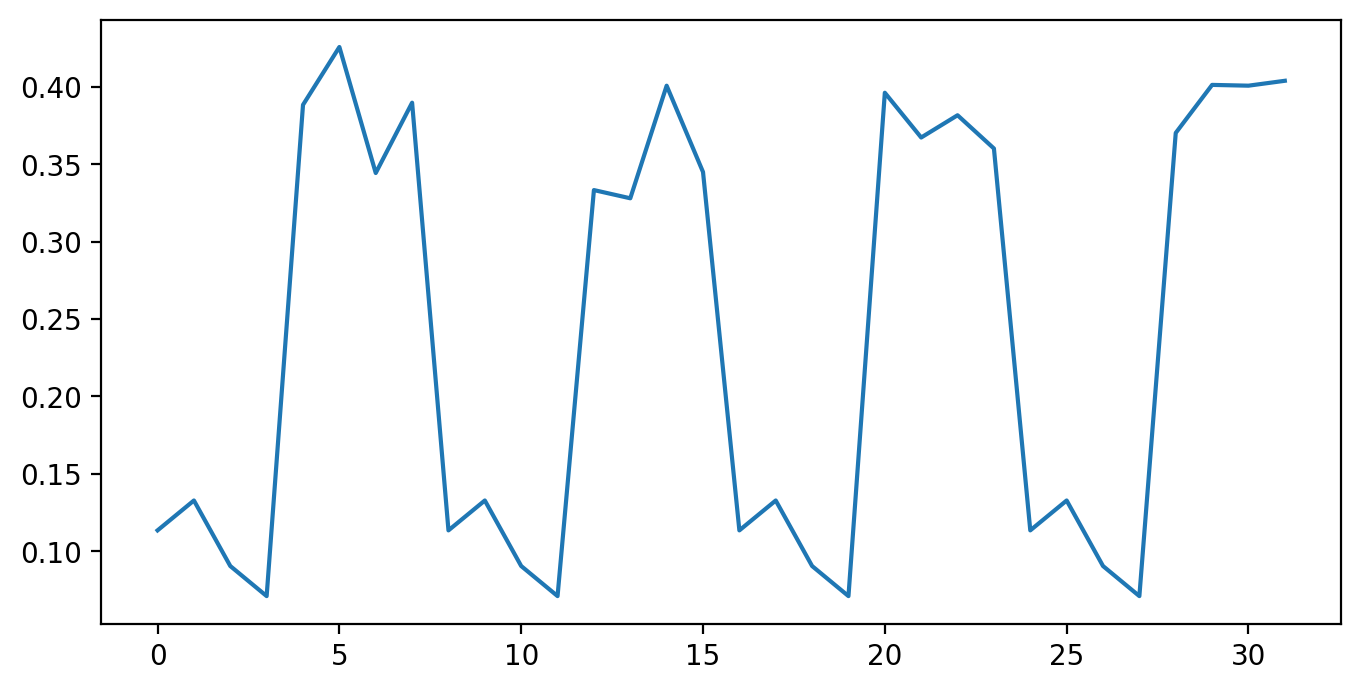

In [14]:
fixed = ((sf.freqs == 0.) | (sf.freqs == 1.))
# what percent of sites are fixed/lost in each replicate? similar prop?
plt.plot(fixed.mean(axis=0))

In [15]:
tile_width = 1e4
tile_width_label = '1e4'
tiles = GenomicIntervals.from_tiles(atonsa.seqlens, width=tile_width, drop_last_tile=False)
#tiles.intervals

In [16]:
d = TiledTemporalFreqs(tiles, freqs=sf.freqs.T, depths=sf.N.T, diploids=3000, gintervals=sf_gi, samples=samples,
                       share_first=True)

In [17]:
np.amax(d.depths.flatten())

912

In [18]:
np.amin(d.depths.flatten())

40

In [19]:
print(-np.sort(-d.depths.flatten()))

[912 912 912 ...  40  40  40]


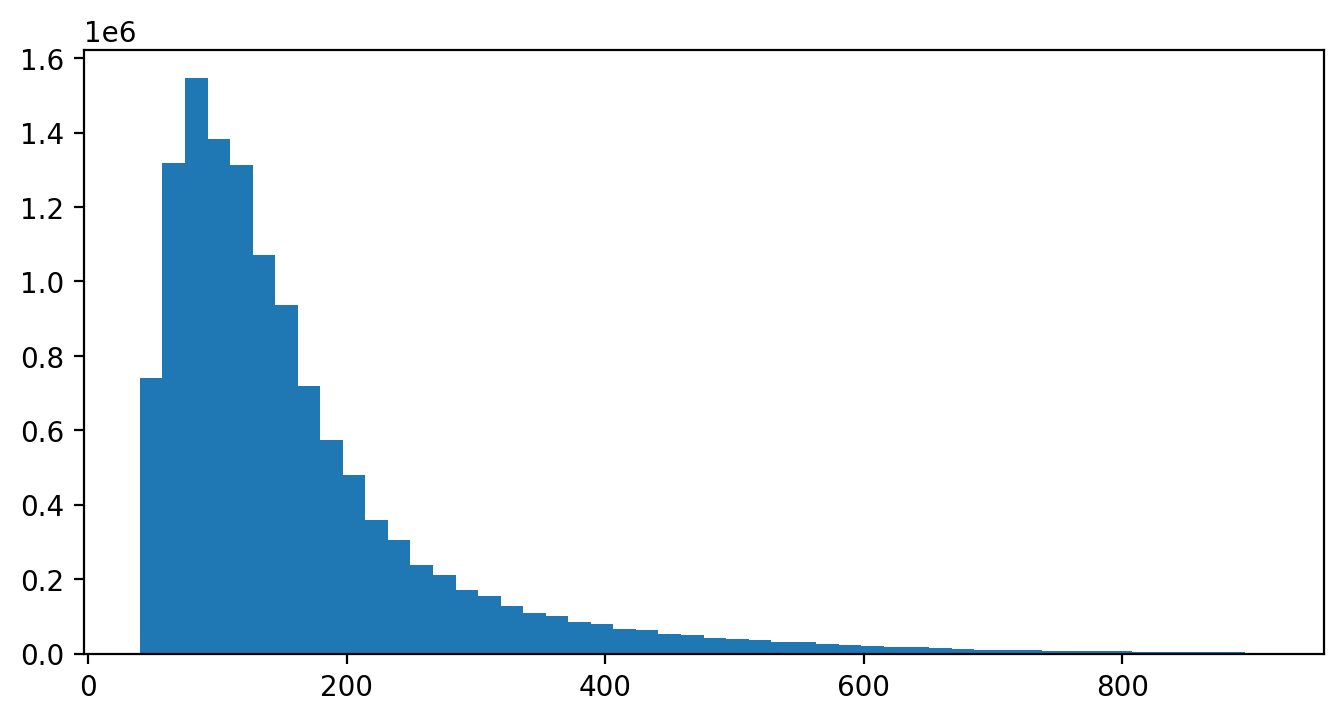

In [20]:
plt.hist(d.depths.flatten(), 50)
plt.show()

In [21]:
d.freqs.shape

(16, 2, 394667)

How many windows and what's the mean and median number of loci per window?

In [22]:
nloci = np.array([len(x) for x in d.tile_indices])

d_noempty = [ele for ele in d.tile_indices if ele != []]
print(len(d_noempty))
print(len(d.tile_indices))

print(f"mean number of loci: {nloci.mean()}")
print(f"median number of loci: {np.median(nloci)}")

9416
42972
mean number of loci: 7.893256073722424
median number of loci: 0.0


## Genome-wide Covariances

In [23]:
gw_covs = d.calc_cov(use_masked=True, standardize=True)

In [24]:
gw_covs.shape

(16, 16)

In [25]:
stack_temporal_covariances(gw_covs, d.R, d.T).mean(axis=2)

array([[0.03950117]])

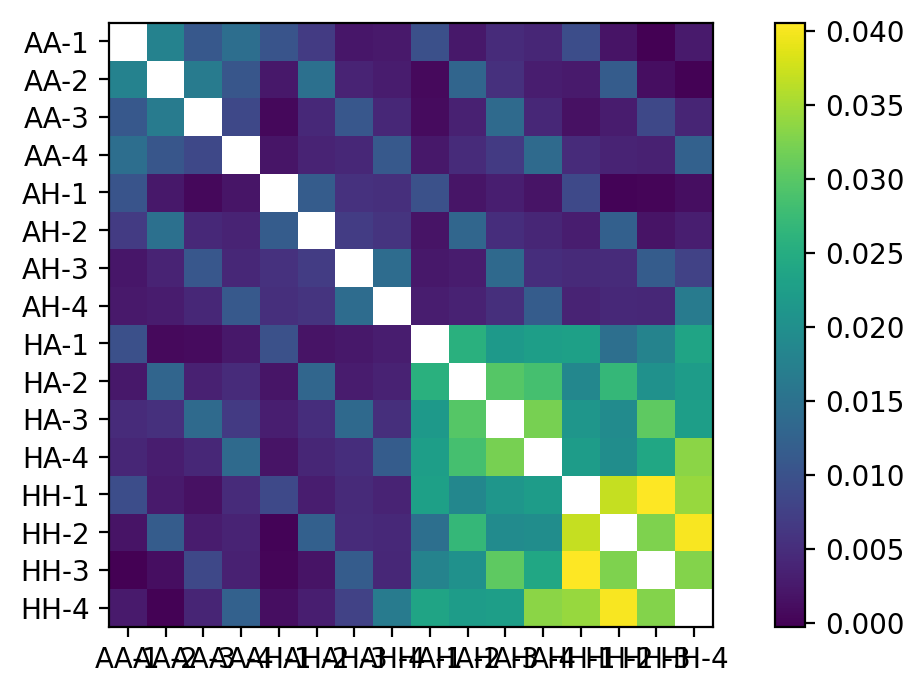

In [26]:
np.fill_diagonal(gw_covs, np.nan)
fig, ax = plt.subplots()
ax.imshow(gw_covs)
img1 = ax.imshow(gw_covs)
fig.colorbar(img1, ax=ax)
sample_names = ['AA-1', 'AA-2', 'AA-3', 'AA-4', 'AH-1', 'AH-2', 'AH-3', 'AH-4', 'HA-1', 'HA-2', 'HA-3', 'HA-4', 'HH-1', 'HH-2', 'HH-3', 'HH-4' ]
ax.set_xticklabels(sample_names)
ax.set_yticklabels(sample_names)
#print( design['name'])
ax.set_xticks(np.arange(len(sample_names)))
ax.set_yticks(np.arange(len(sample_names)))
plt.show()

## Filter windows

In [27]:
#d.tile_df['uniqid'] = d.tile_df['seqid'] + "_" + d.tile_df['midpoint'].astype(str)

# get chrs at least 1kb, so they can have at least 1 window
x2={s:v for s,v in d.tiles.seqlens.items() if v > 999}

# can filter by the number of snps 
## each entry in tile_indices are the snps. 
## so we can drop any scaffold that has windows with zero snps (or whatever number)
min_sites = 0
keep_seqids = list(set([str(chr) for chr, indices in zip(d.tile_df['seqid'], d.tile_indices) if len(indices) > min_sites]))
#sel_chrs = ['24', '1', '9', '15']
#sel_chrs = ['24']
sel_chrs = []
keep_seqids_nolength = [chr for chr in keep_seqids if chr not in sel_chrs]
print("Number of scaffolds with at least 1 snp:",len(keep_seqids))

keep_seqids = set(keep_seqids_nolength).intersection(set(x2.keys()))

print("Number of scaffolds with at least 1 snp and 1kb in length:",len(keep_seqids))

print("Number of total tiles:",len(d.tile_indices))

Number of scaffolds with at least 1 snp: 8416
Number of scaffolds with at least 1 snp and 1kb in length: 8106
Number of total tiles: 42972


In [28]:
exclude_seqids = list(set(d.gintervals.keys()) - set(keep_seqids))
#len(exclude_seqids)

print("Number of scaffolds: ", len(set(d.gintervals.keys())))
print("Number of scaffolds excluded:", len(exclude_seqids))

Number of scaffolds:  9771
Number of scaffolds excluded: 1665


## Bootstrap whole covaraince matrix.

In [29]:
# keep_seqids was a set. need to convert
keep_seqids=list(keep_seqids)

In [30]:
# need to use CI method "standard" to deal with bias in the bootstrap
gw_covs_cis = d.bootstrap_cov(B=1000, progress_bar=True, keep_seqids=keep_seqids,
                              average_replicates=False, use_masked=True, ci_method="standard")

/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cov.py:316: RuntimeWarning: Mean of empty slice
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cov.py:375: RuntimeWarning: Mean of empty slice


In [31]:
# save values:
sample_names = ['AA-1', 'AA-2', 'AA-3', 'AA-4', 'AH-1', 'AH-2', 'AH-3', 'AH-4', 'HA-1', 'HA-2', 'HA-3', 'HA-4', 'HH-1', 'HH-2', 'HH-3', 'HH-4' ]

rows, cols = np.triu_indices(gw_covs_cis.shape[1], k=1)
lower, mean, upper = [gw_covs_cis[i, rows, cols].ravel() for i in np.arange(3)]
all_labels = [sample_names[i] + " " + sample_names[j] for i, j in zip(rows, cols)]
lower, upper = mean-lower, upper-mean

output = pd.DataFrame(
    {'labels': all_labels,
     'lower': lower,
     'upper': upper,
     'mean': mean
    })

output.to_csv('/users/r/b/rbrennan/tonsa_genomics/analysis/covariance_pairwise.csv', index=False)

In [32]:
gw_covs_cis[:,0,1]

array([0.0162338 , 0.01913293, 0.02203207])

In [33]:
# get the bootstrap vals
gw_covs_straps = d.bootstrap_cov(B=1000, progress_bar=True, keep_seqids=keep_seqids,
                              average_replicates=False, use_masked=True,
                             return_straps=True)

KeyboardInterrupt: 

In [ ]:
#print(len(gw_covs_straps[0][2]))
#print(np.ndim(gw_covs_straps[0][2]))
#print((gw_covs_straps[0][2]))
#plt.hist(gw_covs_straps[:,0,0])
straps, weights = gw_covs_straps
mn_all = np.mean(straps[:,0,1])
print("mean: ", mn_all)
conf_interval = np.percentile(straps[:,0,1],[2.5,97.5])
print("conf interval: ", conf_interval)
plt.hist(straps[:,0,1], bins=50, edgecolor='black')
#gw_covs_straps
#plt.hist(weights, bins=100)
array_masked = np.ma.masked_invalid(straps[:,0,0])
#print(np.ma.average(array_masked, axis=0, weights=weights).data)
#print(array_masked)

In [ ]:

def rep_cov_plot(cis, labels='', filename=''):
    rows, cols = np.triu_indices(cis.shape[1], k=1)
    lower, mean, upper = [cis[i, rows, cols].ravel() for i in np.arange(3)]
    all_labels = [labels[i] + " " + labels[j] for i, j in zip(rows, cols)]
    lower, upper = mean-lower, upper-mean
    bounds = np.stack([lower, upper])
    plt.figure(figsize=(8,4)) 
    plt.errorbar(all_labels, mean, yerr=bounds, capsize=0, fmt='o', linewidth=1.5, elinewidth=2)
    plt.axhline(y=0, c='0.6', linewidth=0.5, zorder=-1, linestyle='--')
    plt.xticks(rotation='vertical',fontsize=3)
    markerline, stemline, baseline, = plt.stem(all_labels, mean,linefmt='k--', bottom = -0.01)
    plt.setp(stemline, linewidth = 0.25)
    plt.setp(baseline, 'linewidth', 0)
    plt.ylim([-0.01, 0.065])
    plt.savefig(filename, bbox_inches='tight')



sample_names = ['AA-1', 'AA-2', 'AA-3', 'AA-4', 'AH-1', 'AH-2', 'AH-3', 'AH-4', 'HA-1', 'HA-2', 'HA-3', 'HA-4', 'HH-1', 'HH-2', 'HH-3', 'HH-4' ]

rep_cov_plot(gw_covs_cis, sample_names,"/users/r/b/rbrennan/tonsa_genomics/figures/covariance_pairwise.pdf")


## Bias correction

In [36]:
diagnostics = d.correction_diagnostics(exclude_seqids=exclude_seqids)

/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cvtk.py:260: RuntimeWarning: Mean of empty slice
  n = np.nanmean(n)
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cvtk.py:274: RuntimeWarning: Mean of empty slice
  het = np.nanmean(het)
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cov.py:316: RuntimeWarning: Mean of empty slice
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/cvtkpy-0.0.1-py3.8.egg/cvtk/cov.py:348: RuntimeWarning: Degrees of freedom <= 0 for slice
/users/r/b/rbrennan/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455

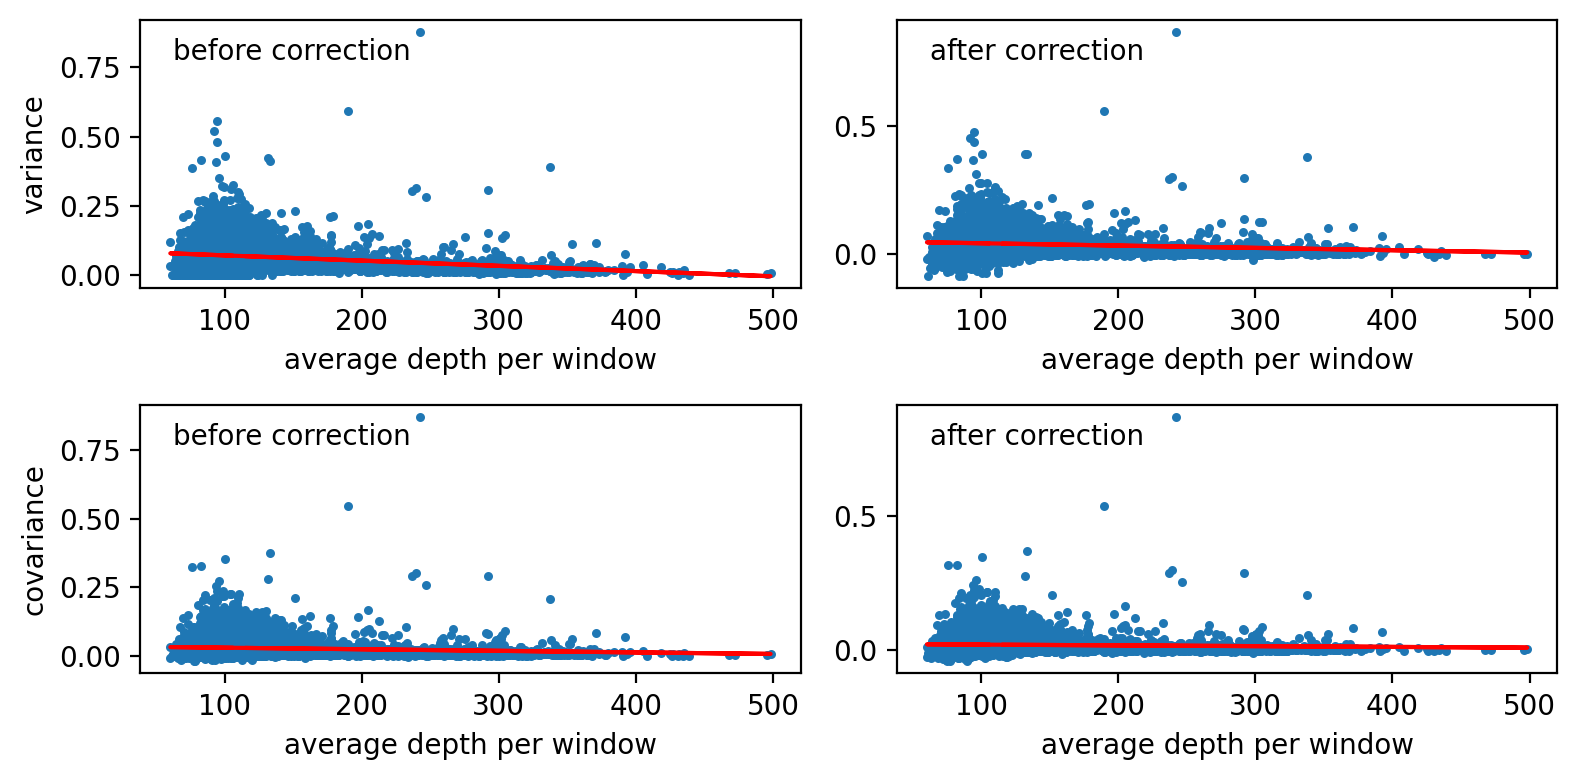

In [37]:
# _ = correction_diagnostic_plot(diagnostics, color=False)
# diagnostic plot from package threw error.
def correction_diagnostic_plot(diag, figsize=None, color=True):
    corr_df, models, xpreds, ypreds = diag
    if figsize is not None:
        fig, ax = plt.subplots(ncols=2, nrows=2, figsize=figsize)
    else:
        fig, ax = plt.subplots(ncols=2, nrows=2)
    labelx, labely = 0.05, 0.85
    before = corr_df[corr_df['correction'] == False]
    after = corr_df[corr_df['correction'] == True]
    if color:
        ax[0, 0].scatter(before['depth'], before['diag'], c=integerize(before['seqid']), s=5)
        ax[0, 1].scatter(before['depth'], after['diag'], c=integerize(before['seqid']), s=5)
    else:
        ax[0, 0].scatter(before['depth'], before['diag'], s=5)
        ax[0, 1].scatter(before['depth'], after['diag'], s=5)
    ax[0, 0].plot(xpreds[False], ypreds[False][0], 'r-')
    ax[0, 1].plot(xpreds[True], ypreds[True][0], 'r-')
    ax[0, 0].annotate('before correction', xy=(labelx, labely), xycoords='axes fraction')
    ax[0, 0].set_ylabel('variance')
    ax[0, 0].set_xlabel('average depth per window')
    ax[0, 1].set_xlabel('average depth per window')
    ax[0, 1].annotate('after correction', xy=(labelx, labely), xycoords='axes fraction')

    ax[1, 0].plot(xpreds[False], ypreds[False][1], 'r-')
    ax[1, 0].annotate('before correction', xy=(labelx, labely), xycoords='axes fraction')
#    ax[1, 0].axhline(y=0, color='99', zorder=1, linestyle='--')
    ax[1, 0].set_ylabel('covariance')
    if color:
        ax[1, 0].scatter(before['depth'], before['offdiag'], c=integerize(before['seqid']),
                         zorder=2, s=5)
        ax[1, 1].scatter(before['depth'], after['offdiag'], c=integerize(before['seqid']),
                         zorder=2, s=5)
    else:
        ax[1, 0].scatter(before['depth'], before['offdiag'], zorder=2, s=5)
        ax[1, 1].scatter(before['depth'], after['offdiag'], zorder=2, s=5)
    ax[1, 1].plot(xpreds[True], ypreds[True][1], 'r-')
    ax[1, 1].annotate('after correction', xy=(labelx, labely), xycoords='axes fraction')
 #   ax[1, 1].axhline(y=0, color='99', zorder=1, linestyle='--')
    ax[1, 0].set_xlabel('average depth per window')
    ax[1, 1].set_xlabel('average depth per window')
    plt.tight_layout()
    return fig, ax

_ = correction_diagnostic_plot(diagnostics, color=False)

## Bootstrap Convergence Correlation

Convergence Correlation per Comparison

In [38]:
import itertools
from cvtk.bootstrap import block_bootstrap

In [39]:
## using the more

In [ ]:
conv_corr = d.convergence_corr()
conv_corr

In [ ]:
convergence_corr = d.bootstrap_convergence_corr(B=10, progress_bar=True)

In [ ]:
convergence_corr

In [48]:
combs = list(itertools.combinations(range(0,16),2))
# just run a couple, to act as example
#combs = list(itertools.combinations(range(0,3),2))

outlist = []

for x in combs:
    outlist.append(
                    d.bootstrap_convergence_corr(B=1000, 
                                                 progress_bar=False, subset=(x[0], x[1]),
                                                 ci_method='standard'))
    print("done with rep", x)

/users/r/b/rbrennan/anaconda3/envs/cvtk/lib/python3.7/site-packages/cvtkpy-0.0.1-py3.7.egg/cvtk/cov.py:316: RuntimeWarning: Mean of empty slice
  mean_hets = np.nanmean(hets, axis=freqs.ndim-1)
/users/r/b/rbrennan/anaconda3/envs/cvtk/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/users/r/b/rbrennan/anaconda3/envs/cvtk/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/users/r/b/rbrennan/anaconda3/envs/cvtk/lib/python3.7/site-packages/cvtkpy-0.0.1-py3.7.egg/cvtk/cov.py:348: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(deltas, bias=True)
/users/r/b/rbrennan/anaconda3/envs/cvtk/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/users/r/b/rbrennan/anaconda3/envs/cvtk/lib/python3.7/site

done with rep (0, 1)
done with rep (0, 2)
done with rep (0, 3)
done with rep (0, 4)
done with rep (0, 5)
done with rep (0, 6)
done with rep (0, 7)
done with rep (0, 8)
done with rep (0, 9)
done with rep (0, 10)
done with rep (0, 11)
done with rep (0, 12)
done with rep (0, 13)
done with rep (0, 14)
done with rep (0, 15)
done with rep (1, 2)
done with rep (1, 3)
done with rep (1, 4)
done with rep (1, 5)
done with rep (1, 6)
done with rep (1, 7)
done with rep (1, 8)
done with rep (1, 9)
done with rep (1, 10)
done with rep (1, 11)
done with rep (1, 12)
done with rep (1, 13)
done with rep (1, 14)
done with rep (1, 15)
done with rep (2, 3)
done with rep (2, 4)
done with rep (2, 5)
done with rep (2, 6)
done with rep (2, 7)
done with rep (2, 8)
done with rep (2, 9)
done with rep (2, 10)
done with rep (2, 11)
done with rep (2, 12)
done with rep (2, 13)
done with rep (2, 14)
done with rep (2, 15)
done with rep (3, 4)
done with rep (3, 5)
done with rep (3, 6)
done with rep (3, 7)
done with rep (3

In [52]:
type(combined_conv_corrs)

numpy.ndarray

In [55]:
combined_conv_corrs = np.stack(outlist).squeeze()
all_labels = [sample_names[i[0]] + " " + sample_names[i[1]] for i in combs]
result = np.hstack((combined_conv_corrs, np.atleast_2d(all_labels).T))

np.savetxt('/users/r/b/rbrennan/tonsa_genomics/scripts/cvtk/combined_conv_corrs.csv', result, delimiter=',', fmt='%s')

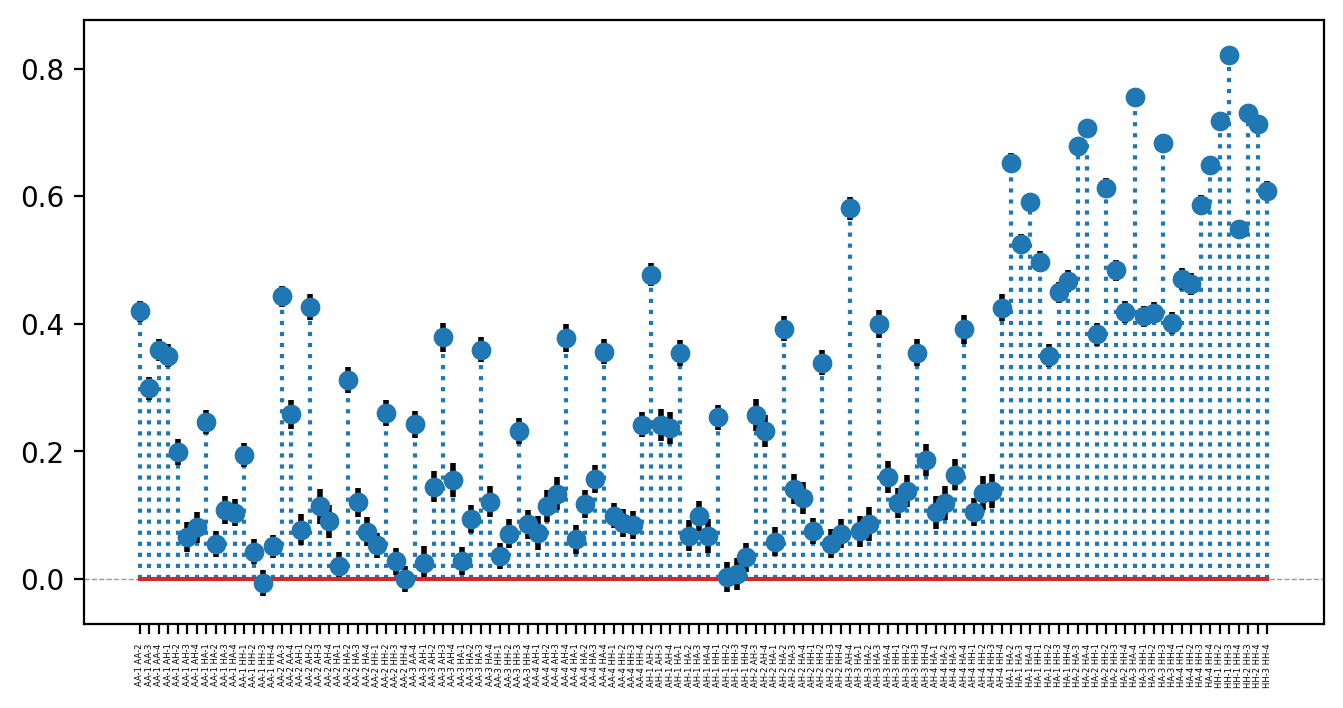

In [56]:
#plt.plot([1, 2, 3, 4])
#plt.ylabel('some numbers')
#plt.show()
    
mean = np.array([x[1] for x in combined_conv_corrs])
lower = np.array([x[0] for x in combined_conv_corrs])
upper = np.array([x[2] for x in combined_conv_corrs])

#print(lower)
#print(mean)
#print(upper)
#upper

all_labels = [sample_names[i[0]] + " " + sample_names[i[1]] for i in combs]

lower_bound, upper_bound = lower-mean, upper-mean
#bounds = [lower_bound, upper_bound]
#print(bounds)
fig = plt.figure()
plt.stem(all_labels, mean, linefmt = ':')

plt.errorbar(all_labels, mean, yerr=upper_bound, capsize=0, fmt='o', linewidth=1.5, elinewidth=2, ecolor="black")
plt.axhline(y=0, c='0.6', linewidth=0.5, zorder=-1, linestyle='--')
plt.xticks(rotation='vertical',fontsize=3)

locs, labels = plt.xticks()
#print(labels)
#plt.axvline(x=locs, c='0.4', linewidth=0.5, linestyle="--")


#sample_names = ['AA-1', 'AA-2', 'AA-3', 'AA-4', 'AH-1', 'AH-2', 'AH-3', 'AH-4', 'HA-1', 'HA-2', 'HA-3', 'HA-4', 'HH-1', 'HH-2', 'HH-3', 'HH-4' ]

#rep_cov_plot(gw_covs_cis, sample_names)

# plt.figure(figsize=(8,4)) 
 #   plt.axhline(y=0, c='0.6', linewidth=0.5, zorder=-1, linestyle='--')
  #  plt.xticks(rotation='vertical',fontsize=3)
    # markerline, stemline, baseline, = plt.stem(all_labels, mean,linefmt='k--', bottom = -0.01)
   # plt.setp(stemline, linewidth = 0.25)
   # plt.setp(baseline, 'linewidth', 0)
   # plt.ylim([-0.01, 0.065])
   # plt.savefig(filename, bbox_inches='tight')

## Genome-wide G
Averaging across replicates:

In [44]:
g_averep = d.calc_G(average_replicates=True)
with open('g_averep_AA.npy', 'wb') as f:
    np.save(f, g_averep)

[0.00317422 0.00356016 0.00269662 0.00311833 0.00218594 0.00258165
 0.00270531 0.00236121 0.00310577 0.00328717 0.00347791 0.00317198
 0.00381188 0.00365817 0.00341534 0.00462489]


Not averaging across replicates:

In [45]:
g = d.calc_G(average_replicates=False)
with open('g.npy', 'wb') as f:
    np.save(f, g)

[0.00317422 0.00356016 0.00269662 0.00311833 0.00218594 0.00258165
 0.00270531 0.00236121 0.00310577 0.00328717 0.00347791 0.00317198
 0.00381188 0.00365817 0.00341534 0.00462489]


### Partitioning Variance into Shared and Unique Contributions

If we use the total variance in af change, can calculate Ne.

First, calc windowed stats for bootstrapping:

In [49]:
windowed_covs = d.calc_cov_by_tile()
win_len_all = len(windowed_covs)
windowed_covs = [windowed_covs for windowed_covs in windowed_covs if ~np.isnan(windowed_covs).any() and ~np.isinf(windowed_covs).any()]
win_len_narm = len(windowed_covs)

In [52]:
%%capture
windowed_vars = d.calc_var_by_tile()
# remove na windows:
#windowed_vars = [windowed_vars for windowed_vars in windowed_vars if ~np.isnan(windowed_vars).any() and ~np.isinf(windowed_vars).any()]


In [53]:
windowed_vars = [windowed_vars for windowed_vars in windowed_vars if ~np.isnan(windowed_vars).any() and ~np.isinf(windowed_vars).any()]

In [54]:
print("All window length", win_len_all)
print("NA rm window length", win_len_narm)

All window length 42972
NA rm window length 9304


In [55]:
from cvtk.bootstrap import bootstrap_ci, block_bootstrap_ratio_averages

In [56]:
gw_vars = d.calc_var()
gw_covs = d.calc_cov()

ambient = (gw_covs[0,1] + gw_covs[0,2] + gw_covs[0,3] + gw_covs[1,2] + gw_covs[1,3] + gw_covs[2,3])/6  
acidic  = (gw_covs[4,5] + gw_covs[4,6] + gw_covs[4,7] + gw_covs[5,6] + gw_covs[5,7] + gw_covs[6,7])/6  
warm    = (gw_covs[8,9] + gw_covs[8,10] + gw_covs[8,11] + gw_covs[9,10] + gw_covs[9,11] + gw_covs[10,11])/6  
GH      = (gw_covs[12,13] + gw_covs[12,14] + gw_covs[12,15] + gw_covs[13,14] + gw_covs[13,15] + gw_covs[14,15])/6  

# total variance for each group:
ambient1 = (gw_vars[0] + gw_vars[1] + gw_vars[2] + gw_vars[3])/4
acidic1  = (gw_vars[4] + gw_vars[5] + gw_vars[6] + gw_vars[7])/4
warm1    = (gw_vars[8] + gw_vars[9] + gw_vars[10] + gw_vars[11])/4
GH1      = (gw_vars[12] + gw_vars[13] + gw_vars[14] + gw_vars[15])/4  

print("total variance ambient",(ambient1).round(4))
print("total variance acidic",(acidic1).round(4))
print("total variance warm",(warm1).round(4))
print("total variance GH",(GH1).round(4))

#then estimate Ne with:

#(V(Pt-P0)/P0(1-P0))=t/2Ne
# where the left side of this is equal to the var estimate, above.
# then Ne = t/2(var)

## bootstrap ne estimtes
# need function to bootstrap over
def unique_shared(cov):
    am_total = (cov[0] + cov[1] + cov[2] + cov[3])/4
    ac_total = (cov[4] + cov[5] + cov[6] + cov[7])/4
    wm_total = (cov[8] + cov[9] + cov[10] + cov[11])/4
    gh_total = (cov[12] + cov[13] + cov[14] + cov[15])/4
    am_ne = am_total
    ac_ne = ac_total
    wm_ne = wm_total
    gh_ne = gh_total
    return am_ne, ac_ne, wm_ne, gh_ne

B = 5000
windowed_stats = np.array([unique_shared(win) for win in windowed_vars])

am_straps, ac_straps, wm_straps, gh_straps = [], [], [], []

for b in np.arange(B):
    bidx = np.random.randint(0, len(windowed_vars), len(windowed_vars))
    am, ac, wm, gh = windowed_stats[bidx, :].mean(axis=0)
    am_straps.append(25/(2*am))
    ac_straps.append(25/(2*ac))
    wm_straps.append(25/(2*wm))
    gh_straps.append(25/(2*gh))

print('Ambient Ne:', (bootstrap_ci(25/(2*ambient1),am_straps, method="standard")).round(2))
print('Acidic Ne:', (bootstrap_ci(25/(2*acidic1),ac_straps, method="standard")).round(2))
print('Warm Ne:', (bootstrap_ci(25/(2*warm1),wm_straps, method="standard")).round(2))
print('GH Ne:', (bootstrap_ci(25/(2*GH1),gh_straps, method="standard")).round(2))

[0.00317422 0.00356016 0.00269662 0.00311833 0.00218594 0.00258165
 0.00270531 0.00236121 0.00310577 0.00328717 0.00347791 0.00317198
 0.00381188 0.00365817 0.00341534 0.00462489]
total variance ambient 0.0464
total variance acidic 0.0317
total variance warm 0.0484
total variance GH 0.0609
Ambient Ne: [264.73 269.65 274.57]
Acidic Ne: [386.85 394.62 402.39]
Warm Ne: [252.52 258.5  264.48]
GH Ne: [200.54 205.18 209.81]


### bootstrap total variance estimate

### shared change due to selection:
    mean(cov between each replicate in that treatment) - mean(cov with ambient control)/(total variance)

In [57]:
# shared change due to Acidic selection

sample_names = ['AA-1', 'AA-2', 'AA-3', 'AA-4', 'AH-1', 'AH-2', 'AH-3', 'AH-4', 'HA-1', 'HA-2', 'HA-3', 'HA-4', 'HH-1', 'HH-2', 'HH-3', 'HH-4' ]
# rows and cols should match sample names, above
gw_covs = d.calc_cov()

# need function to bootstrap over
def unique_shared(cov):
    shared = (cov[4,5] + cov[4,6] + cov[4,7] + cov[5,6] + cov[5,7] + cov[6,7])/6  
    lab = (cov[0,4] + cov[0,5] + cov[0,6] + cov[0,7] + cov[1,4] + cov[1,5] + cov[1,6] + cov[1,7] + cov[2,4] + cov[2,5] + cov[2,6] + cov[2,7] + cov[3,4] + cov[3,5] + cov[3,6] + cov[3,7])/16
    total = (cov[4,4] + cov[5,5] + cov[6,6] + cov[7,7])/4
    return shared, lab, total

shared, lab, total = unique_shared(gw_covs)

selection = (shared - lab)/total

## bootstrap

B = 5000
windowed_stats = np.array([unique_shared(win) for win in windowed_covs])

shared_straps, lab_straps, total_straps, selection_straps = [], [], [], []
for b in np.arange(B):
    bidx = np.random.randint(0, len(windowed_covs), len(windowed_covs))
    s, l, t = windowed_stats[bidx, :].mean(axis=0)
    shared_straps.append(s/t)
    lab_straps.append(l/t)
    selection_straps.append((s-l)/t)
    total_straps.append(t)


acidic_total_var = (bootstrap_ci(total,total_straps, method="standard")).round(4)
acidic_shared_var = (bootstrap_ci(shared/total,shared_straps, method="standard")*100).round(3)
acidic_lab_var = (bootstrap_ci(lab/total,lab_straps, method="standard")*100).round(3)
acidic_selection_var = (bootstrap_ci(selection,selection_straps, method="standard")*100).round(3)

print('total variance:', acidic_total_var)
print('shared:', acidic_shared_var)
print('lab:', acidic_lab_var)
print('selection:', acidic_selection_var)

total variance: [0.0238 0.0243 0.0249]
shared: [32.164 33.739 35.313]
lab: [20.41  22.359 24.308]
selection: [ 9.835 11.38  12.924]


### repeat for Warm

In [58]:
# shared change due to Warm selection
def unique_shared(cov):
    shared = (cov[8,9] + cov[8,10] + cov[8,11] + cov[9,10] + cov[9,11] + cov[10,11])/6  
    lab = (cov[0,8] + cov[0,9] + cov[0,10] + cov[0,11] + cov[1,8] + cov[1,9] + cov[1,10] + cov[1,11] + cov[2,8] + cov[2,9] + cov[2,10] + cov[2,11] + cov[3,8] + cov[3,9] +cov[3,10] + cov[3,11])/16
    total = (cov[8,8] + cov[9,9] + cov[10,10] + cov[11,11])/4
    return shared, lab, total

shared, lab, total = unique_shared(gw_covs)

selection = (shared - lab)/total

## bootstrap

B = 5000
windowed_stats = np.array([unique_shared(win) for win in windowed_covs])

shared_straps, lab_straps, total_straps, selection_straps = [], [], [], []
for b in np.arange(B):
    bidx = np.random.randint(0, len(windowed_covs), len(windowed_covs))
    s, l, t = windowed_stats[bidx, :].mean(axis=0)
    shared_straps.append(s/t)
    lab_straps.append(l/t)
    selection_straps.append((s-l)/t)
    total_straps.append(t)


warm_total_var = (bootstrap_ci(total,total_straps, method="standard")).round(4)
warm_shared_var = (bootstrap_ci(shared/total,shared_straps, method="standard")*100).round(3)
warm_lab_var = (bootstrap_ci(lab/total,lab_straps, method="standard")*100).round(3)
warm_selection_var = (bootstrap_ci(selection,selection_straps, method="standard")*100).round(3)

print('total variance:', warm_total_var)
print('shared:', warm_shared_var)
print('lab:', warm_lab_var)
print('selection:', warm_selection_var)

total variance: [0.0399 0.041  0.0422]
shared: [64.298 65.237 66.177]
lab: [12.968 14.272 15.576]
selection: [49.503 50.965 52.428]


### Repeat for GH

In [59]:
# shared change due to GH selection
def unique_shared(cov):
    shared = (cov[12,13] + cov[12,14] + cov[12,15] + cov[13,14] + cov[13,15] + cov[14,15])/6  
    lab = (cov[0,12] + cov[0,13] + cov[0,14] + cov[0,15] + cov[1,12] + cov[1,13] + cov[1,14] + cov[1,15] + cov[2,12] + cov[2,13] + cov[2,14] + cov[2,15] + cov[3,12] + cov[3,13] +cov[3,14] + cov[3,15])/16
    total = (cov[12,12] + cov[13,13] + cov[14,14] + cov[15,15])/4
    return shared, lab, total

shared, lab, total = unique_shared(gw_covs)

selection = (shared - lab)/total

## bootstrap

B = 5000
windowed_stats = np.array([unique_shared(win) for win in windowed_covs])

shared_straps, lab_straps, total_straps, selection_straps = [], [], [], []
for b in np.arange(B):
    bidx = np.random.randint(0, len(windowed_covs), len(windowed_covs))
    s, l, t = windowed_stats[bidx, :].mean(axis=0)
    shared_straps.append(s/t)
    lab_straps.append(l/t)
    selection_straps.append((s-l)/t)
    total_straps.append(t)


GH_total_var = (bootstrap_ci(total,total_straps, method="standard")).round(4)
GH_shared_var = (bootstrap_ci(shared/total,shared_straps, method="standard")*100).round(3)
GH_lab_var = (bootstrap_ci(lab/total,lab_straps, method="standard")*100).round(3)
GH_selection_var = (bootstrap_ci(selection,selection_straps, method="standard")*100).round(3)

print('total variance:', GH_total_var)
print('shared:', GH_shared_var)
print('lab:', GH_lab_var)
print('selection:', GH_selection_var)

total variance: [0.0521 0.0536 0.0551]
shared: [66.892 67.615 68.338]
lab: [7.276 8.228 9.179]
selection: [58.323 59.387 60.451]


## Shared response between treatments:

shared_cov = mean(cov between replicates of the two treatments)  
lab_cov = mean(cov between each replicate and the control)

then the total shared covariance without lab effects:

(shared_cov - lab_cov) / (total variance)

In [60]:
# shared change in Acidic vs GH

def unique_shared(cov):
    shared = (cov[4,12] + cov[4,13] + cov[4,14] + cov[4,15] + cov[5,12] +cov[5,13] + cov[5,14] + \
                  cov[5,15] + cov[6,12] + cov[6,13] + cov[6,14] + cov[6,15] + cov[7,12] + cov[7,13] + \
                  cov[7,14] + cov[7,15])/16
    lab = (cov[0,4] + cov[0,5] + cov[0,6] + cov[0,7] + cov[1,4] + cov[1,5] + cov[1,6] + cov[1,7] + \
               cov[2,4] + cov[2,5] + cov[2,6] + cov[2,7] + cov[3,4] + cov[3,5] + cov[3,6] + cov[3,7] + \
               cov[0,12] + cov[0,13] + cov[0,14] + cov[0,15] + cov[1,12] + cov[1,13] + cov[1,14] + cov[1,15] + \
               cov[2,12] + cov[2,13] + cov[2,14] + cov[2,15] + cov[3,12] + cov[3,13] + cov[3,14] + cov[3,15])/32
    total = (cov[4,4] + cov[5,5] + cov[6,6] + cov[7,7] + cov[12,12] + cov[13,13] + cov[14,14] + cov[15,15] )/8
    return shared, lab, total

shared, lab, total = unique_shared(gw_covs)

selection = (shared - lab)

## bootstrap

B = 5000
windowed_stats = np.array([unique_shared(win) for win in windowed_covs])

shared_straps, lab_straps, total_straps, selection_straps = [], [], [], []
for b in np.arange(B):
    bidx = np.random.randint(0, len(windowed_covs), len(windowed_covs))
    s, l, t = windowed_stats[bidx, :].mean(axis=0)
    shared_straps.append(s/t)
    lab_straps.append(l/t)
    selection_straps.append((s-l)/t)
    total_straps.append(t)

GH_ac_total_var = (bootstrap_ci(total,total_straps, method="standard")).round(4)
GH_ac_shared_var = (bootstrap_ci(shared/total,shared_straps, method="standard")*100).round(3)
GH_ac_lab_var = (bootstrap_ci(lab/total,lab_straps, method="standard")*100).round(3)
GH_ac_selection_var = (bootstrap_ci(selection/total,selection_straps, method="standard")*100).round(3)

print('total variance:', GH_ac_total_var)
print('shared:', GH_ac_shared_var)
print('lab:', GH_ac_lab_var)
print('selection:', GH_ac_selection_var)

total variance: [0.0381 0.039  0.0399]
shared: [12.899 14.239 15.579]
lab: [11.497 12.642 13.788]
selection: [0.492 1.597 2.701]


In [61]:
# shared change in Acidic vs Warm

def unique_shared(cov):
    shared =     (cov[4,8] + cov[4,9] + cov[4,10] + cov[4,11] + cov[5,8] +cov[5,9] + cov[5,10] + \
                  cov[5,11] + cov[6,8] + cov[6,9] + cov[6,10] + cov[6,11] + cov[7,8] + cov[7,9] + \
                  cov[7,10] + cov[7,11])/16
    lab = (cov[0,4] + cov[0,5] + cov[0,6] + cov[0,7] + cov[1,4] + cov[1,5] + cov[1,6] + cov[1,7] + \
               cov[2,4] + cov[2,5] + cov[2,6] + cov[2,7] + cov[3,4] + cov[3,5] + cov[3,6] + cov[3,7] + \
               cov[0,8] + cov[0,9] + cov[0,10] + cov[0,11] + cov[1,8] + cov[1,9] + cov[1,10] + cov[1,11] + \
               cov[2,8] + cov[2,9] + cov[2,10] + cov[2,11] + cov[3,8] + cov[3,9] + cov[3,10] + cov[3,11])/32
    total = (cov[4,4] + cov[5,5] + cov[6,6] + cov[7,7] + cov[8,8] + cov[9,9] + cov[10,10] + cov[11,11] )/8
    return shared, lab, total

shared, lab, total = unique_shared(gw_covs)

selection = (shared - lab)

## bootstrap

B = 5000
windowed_stats = np.array([unique_shared(win) for win in windowed_covs])

shared_straps, lab_straps, total_straps, selection_straps = [], [], [], []
for b in np.arange(B):
    bidx = np.random.randint(0, len(windowed_covs), len(windowed_covs))
    s, l, t = windowed_stats[bidx, :].mean(axis=0)
    shared_straps.append(s/t)
    lab_straps.append(l/t)
    selection_straps.append((s-l)/t)
    total_straps.append(t)

wm_ac_total_var = (bootstrap_ci(total,total_straps, method="standard")).round(4)
wm_ac_shared_var = (bootstrap_ci(shared/total,shared_straps, method="standard")*100).round(3)
wm_ac_lab_var = (bootstrap_ci(lab/total,lab_straps, method="standard")*100).round(3)
wm_ac_selection_var = (bootstrap_ci(selection/total,selection_straps, method="standard")*100).round(3)

print('total variance:', wm_ac_total_var)
print('shared:', wm_ac_shared_var)
print('lab:', wm_ac_lab_var)
print('selection:', wm_ac_selection_var)

total variance: [0.032  0.0327 0.0334]
shared: [15.619 17.038 18.457]
lab: [15.879 17.284 18.689]
selection: [-1.356 -0.246  0.863]


In [62]:
# shared change in GH vs Warm

def unique_shared(cov):
    shared =     (cov[12,8] + cov[12,9] + cov[12,10] + cov[12,11] + cov[13,8] +cov[13,9] + cov[13,10] + \
                  cov[13,11] + cov[14,8] + cov[14,9] + cov[14,10] + cov[14,11] + cov[15,8] + cov[15,9] + \
                  cov[15,10] + cov[15,11])/16
    lab = (cov[0,12] + cov[0,13] + cov[0,14] + cov[0,15] + cov[1,12] + cov[1,13] + cov[1,14] + cov[1,15] + \
               cov[2,12] + cov[2,13] + cov[2,14] + cov[2,15] + cov[3,12] + cov[3,13] + cov[3,14] + cov[3,15] + \
               cov[0,8] + cov[0,9] + cov[0,10] + cov[0,11] + cov[1,8] + cov[1,9] + cov[1,10] + cov[1,11] + \
               cov[2,8] + cov[2,9] + cov[2,10] + cov[2,11] + cov[3,8] + cov[3,9] + cov[3,10] + cov[3,11])/32
    total = (cov[12,12] + cov[13,13] + cov[14,14] + cov[15,15] + cov[8,8] + cov[9,9] + cov[10,10] + cov[11,11] )/8
    return shared, lab, total

shared, lab, total = unique_shared(gw_covs)

selection = (shared - lab)

## bootstrap

B = 5000
windowed_stats = np.array([unique_shared(win) for win in windowed_covs])

shared_straps, lab_straps, total_straps, selection_straps = [], [], [], []
for b in np.arange(B):
    bidx = np.random.randint(0, len(windowed_covs), len(windowed_covs))
    s, l, t = windowed_stats[bidx, :].mean(axis=0)
    shared_straps.append(s/t)
    lab_straps.append(l/t)
    selection_straps.append((s-l)/t)
    total_straps.append(t)

GH_wm_total_var = (bootstrap_ci(total,total_straps, method="standard")).round(4)
GH_wm_shared_var = (bootstrap_ci(shared/total,shared_straps, method="standard")*100).round(3)
GH_wm_lab_var = (bootstrap_ci(lab/total,lab_straps, method="standard")*100).round(3)
GH_wm_selection_var = (bootstrap_ci(selection/total,selection_straps, method="standard")*100).round(3)

print('total variance:', GH_wm_total_var)
print('shared:', GH_wm_shared_var)
print('lab:', GH_wm_lab_var)
print('selection:', GH_wm_selection_var)

total variance: [0.0461 0.0473 0.0485]
shared: [46.489 47.603 48.717]
lab: [ 9.82  10.849 11.878]
selection: [35.48  36.754 38.029]


### save output from bootstraps for plotting

In [63]:
data= [['GH', 'total',GH_total_var[0],GH_total_var[1],GH_total_var[2]],
    ['GH', 'shared',GH_shared_var[0],GH_shared_var[1],GH_shared_var[2]],
    ['GH', 'lab',GH_lab_var[0],GH_lab_var[1],GH_lab_var[2]],
    ['GH', 'selection',GH_selection_var[0],GH_selection_var[1],GH_selection_var[2]],
    ['warm', 'total',warm_total_var[0],warm_total_var[1],warm_total_var[2]],
    ['warm', 'shared',warm_shared_var[0],warm_shared_var[1],warm_shared_var[2]],
    ['warm', 'lab',warm_lab_var[0],warm_lab_var[1],warm_lab_var[2]],
    ['warm', 'selection',warm_selection_var[0],warm_selection_var[1],warm_selection_var[2]],
    ['acidic', 'total',acidic_total_var[0],acidic_total_var[1],acidic_total_var[2]],
    ['acidic', 'shared',acidic_shared_var[0],acidic_shared_var[1],acidic_shared_var[2]],
    ['acidic', 'lab',acidic_lab_var[0],acidic_lab_var[1],acidic_lab_var[2]],
    ['acidic', 'selection',acidic_selection_var[0],acidic_selection_var[1],acidic_selection_var[2]]]

# create df:
df = pd.DataFrame(data, columns = ['treatment', 'var_group', 'lower_err', 'estimate', 'upper_err'])
df.to_csv('/users/r/b/rbrennan/tonsa_genomics/analysis/total_variance.csv', index=False)
df

,treatment,var_group,lower_err,estimate,upper_err
0,GH,total,0.0521,0.0536,0.0551
1,GH,shared,66.8920,67.6150,68.3380
2,GH,lab,7.2760,8.2280,9.1790
3,GH,selection,58.3230,59.3870,60.4510
4,warm,total,0.0399,0.0410,0.0422
5,warm,shared,64.2980,65.2370,66.1770
6,warm,lab,12.9680,14.2720,15.5760
7,warm,selection,49.5030,50.9650,52.4280
8,acidic,total,0.0238,0.0243,0.0249
9,acidic,shared,32.1640,33.7390,35.3130


In [64]:
# then save the treatment covariances
data= [['GH_warm', 'total',GH_wm_total_var[0],GH_wm_total_var[1],GH_wm_total_var[2]],
    ['GH_warm', 'shared',GH_wm_shared_var[0],GH_wm_shared_var[1],GH_wm_shared_var[2]],
    ['GH_warm', 'lab',GH_wm_lab_var[0],GH_wm_lab_var[1],GH_wm_lab_var[2]],
    ['GH_warm', 'selection',GH_wm_selection_var[0],GH_wm_selection_var[1],GH_wm_selection_var[2]],
    ['warm_acidic', 'total',    wm_ac_total_var[0],wm_ac_total_var[1],wm_ac_total_var[2]],
    ['warm_acidic', 'shared',   wm_ac_shared_var[0],wm_ac_shared_var[1],wm_ac_shared_var[2]],
    ['warm_acidic', 'lab',      wm_ac_lab_var[0],wm_ac_lab_var[1],wm_ac_lab_var[2]],
    ['warm_acidic', 'selection',wm_ac_selection_var[0],wm_ac_selection_var[1],wm_ac_selection_var[2]],
    ['GH_acidic', 'total',      GH_ac_total_var[0],GH_ac_total_var[1],GH_ac_total_var[2]],
    ['GH_acidic', 'shared',     GH_ac_shared_var[0],GH_ac_shared_var[1],GH_ac_shared_var[2]],
    ['GH_acidic', 'lab',        GH_ac_lab_var[0],GH_ac_lab_var[1],GH_ac_lab_var[2]],
    ['GH_acidic', 'selection',  GH_ac_selection_var[0],GH_ac_selection_var[1],GH_ac_selection_var[2]]]

# create df:
df = pd.DataFrame(data, columns = ['treatment', 'var_group', 'lower_err', 'estimate', 'upper_err'])

df.to_csv('/users/r/b/rbrennan/tonsa_genomics/analysis/shared_variance.csv', index=False)

df

,treatment,var_group,lower_err,estimate,upper_err
0,GH_warm,total,0.0461,0.0473,0.0485
1,GH_warm,shared,46.4890,47.6030,48.7170
2,GH_warm,lab,9.8200,10.8490,11.8780
3,GH_warm,selection,35.4800,36.7540,38.0290
4,warm_acidic,total,0.0320,0.0327,0.0334
5,warm_acidic,shared,15.6190,17.0380,18.4570
6,warm_acidic,lab,15.8790,17.2840,18.6890
7,warm_acidic,selection,-1.3560,-0.2460,0.8630
8,GH_acidic,total,0.0381,0.0390,0.0399
9,GH_acidic,shared,12.8990,14.2390,15.5790


## REMOVE inflated reps
### Partitioning Variance into Shared and Unique Contributions

### shared change due to selection:
    mean(cov between each replicate in that treatment) - mean(cov with ambient control)/(total variance)

In [65]:
# shared change due to Acidic selection

sample_names = ['AA-1', 'AA-2', 'AA-3', 'AA-4', 'AH-1', 'AH-2', 'AH-3', 'AH-4', 'HA-1', 'HA-2', 'HA-3', 'HA-4', 'HH-1', 'HH-2', 'HH-3', 'HH-4' ]
# rows and cols should match sample names, above
gw_covs = d.calc_cov()

# need function to bootstrap over
def unique_shared(cov):
    shared = (cov[4,5] + cov[4,6] + cov[4,7] + cov[5,6] + cov[5,7] + cov[6,7])/6  
    lab = (cov[0,5] + cov[0,6] + cov[0,7] + cov[1,4] + cov[1,6] + cov[1,7] + cov[2,4] + cov[2,5] + cov[2,7] + cov[3,4] + cov[3,5] + cov[3,6])/12
    total = (cov[4,4] + cov[5,5] + cov[6,6] + cov[7,7])/4
    return shared, lab, total

shared, lab, total = unique_shared(gw_covs)

selection = (shared - lab)/total

## bootstrap

B = 5000
windowed_stats = np.array([unique_shared(win) for win in windowed_covs])

shared_straps, lab_straps, total_straps, selection_straps = [], [], [], []
for b in np.arange(B):
    bidx = np.random.randint(0, len(windowed_covs), len(windowed_covs))
    s, l, t = windowed_stats[bidx, :].mean(axis=0)
    shared_straps.append(s/t)
    lab_straps.append(l/t)
    selection_straps.append((s-l)/t)
    total_straps.append(t)


acidic_total_var = (bootstrap_ci(total,total_straps, method="standard")).round(4)
acidic_shared_var = (bootstrap_ci(shared/total,shared_straps, method="standard")*100).round(3)
acidic_lab_var = (bootstrap_ci(lab/total,lab_straps, method="standard")*100).round(3)
acidic_selection_var = (bootstrap_ci(selection,selection_straps, method="standard")*100).round(3)

print('total variance:', acidic_total_var)
print('shared:', acidic_shared_var)
print('lab:', acidic_lab_var)
print('selection:', acidic_selection_var)

total variance: [0.0237 0.0243 0.025 ]
shared: [32.176 33.739 35.301]
lab: [11.568 13.665 15.763]
selection: [18.463 20.073 21.683]


### repeat for Warm

In [66]:
# shared change due to Warm selection
def unique_shared(cov):
    shared = (cov[8,9] + cov[8,10] + cov[8,11] + cov[9,10] + cov[9,11] + cov[10,11])/6  
    lab = (cov[0,9] + cov[0,10] + cov[0,11] + cov[1,8] + cov[1,10] + cov[1,11] + cov[2,8] + cov[2,9]+ cov[2,11] + cov[3,8] + cov[3,9] +cov[3,10])/12
    total = (cov[8,8] + cov[9,9] + cov[10,10] + cov[11,11])/4
    return shared, lab, total

shared, lab, total = unique_shared(gw_covs)

selection = (shared - lab)/total

## bootstrap

B = 5000
windowed_stats = np.array([unique_shared(win) for win in windowed_covs])

shared_straps, lab_straps, total_straps, selection_straps = [], [], [], []
for b in np.arange(B):
    bidx = np.random.randint(0, len(windowed_covs), len(windowed_covs))
    s, l, t = windowed_stats[bidx, :].mean(axis=0)
    shared_straps.append(s/t)
    lab_straps.append(l/t)
    selection_straps.append((s-l)/t)
    total_straps.append(t)


warm_total_var = (bootstrap_ci(total,total_straps, method="standard")).round(4)
warm_shared_var = (bootstrap_ci(shared/total,shared_straps, method="standard")*100).round(3)
warm_lab_var = (bootstrap_ci(lab/total,lab_straps, method="standard")*100).round(3)
warm_selection_var = (bootstrap_ci(selection,selection_straps, method="standard")*100).round(3)

print('total variance:', warm_total_var)
print('shared:', warm_shared_var)
print('lab:', warm_lab_var)
print('selection:', warm_selection_var)

total variance: [0.0399 0.041  0.0422]
shared: [64.298 65.237 66.177]
lab: [ 7.423  8.771 10.12 ]
selection: [55.064 56.466 57.868]


### Repeat for GH

In [67]:
# shared change due to GH selection
def unique_shared(cov):
    shared = (cov[12,13] + cov[12,14] + cov[12,15] + cov[13,14] + cov[13,15] + cov[14,15])/6  
    lab = (cov[0,13] + cov[0,14] + cov[0,15] + cov[1,12] + cov[1,14] + cov[1,15] + cov[2,12] + cov[2,13] + cov[2,15] + cov[3,12] + cov[3,13] +cov[3,14])/12
    total = (cov[12,12] + cov[13,13] + cov[14,14] + cov[15,15])/4
    return shared, lab, total

shared, lab, total = unique_shared(gw_covs)

selection = (shared - lab)/total

## bootstrap

B = 5000
windowed_stats = np.array([unique_shared(win) for win in windowed_covs])

shared_straps, lab_straps, total_straps, selection_straps = [], [], [], []
for b in np.arange(B):
    bidx = np.random.randint(0, len(windowed_covs), len(windowed_covs))
    s, l, t = windowed_stats[bidx, :].mean(axis=0)
    shared_straps.append(s/t)
    lab_straps.append(l/t)
    selection_straps.append((s-l)/t)
    total_straps.append(t)


GH_total_var = (bootstrap_ci(total,total_straps, method="standard")).round(4)
GH_shared_var = (bootstrap_ci(shared/total,shared_straps, method="standard")*100).round(3)
GH_lab_var = (bootstrap_ci(lab/total,lab_straps, method="standard")*100).round(3)
GH_selection_var = (bootstrap_ci(selection,selection_straps, method="standard")*100).round(3)

print('total variance:', GH_total_var)
print('shared:', GH_shared_var)
print('lab:', GH_lab_var)
print('selection:', GH_selection_var)

total variance: [0.0521 0.0536 0.0551]
shared: [66.888 67.615 68.343]
lab: [3.464 4.442 5.421]
selection: [62.114 63.173 64.232]


## Shared response between treatments:

shared_cov = mean(cov between replicates of the two treatments)  
lab_cov = mean(cov between each replicate and the control)

then the total shared covariance without lab effects:

(shared_cov - lab_cov) / (total variance)

In [68]:
# shared change in Acidic vs GH

def unique_shared(cov):
    shared = (cov[4,13] + cov[4,14] + cov[4,15] + cov[5,12] + cov[5,14] + \
                  cov[5,15] + cov[6,12] + cov[6,13] + cov[6,15] + cov[7,12] + cov[7,13] + \
                  cov[7,14])/12
    lab = (cov[0,5] + cov[0,6] + cov[0,7] + cov[1,4] + cov[1,6] + cov[1,7] + \
               cov[2,4] + cov[2,5] + cov[2,7] + cov[3,4] + cov[3,5] + cov[3,6] + \
               cov[0,13] + cov[0,14] + cov[0,15] + cov[1,12] + cov[1,14] + cov[1,15] + \
               cov[2,12] + cov[2,13] + cov[2,15] + cov[3,12] + cov[3,13] + cov[3,14])/24
    total = (cov[4,4] + cov[5,5] + cov[6,6] + cov[7,7] + cov[12,12] + cov[13,13] + cov[14,14] + cov[15,15] )/8
    return shared, lab, total

shared, lab, total = unique_shared(gw_covs)

selection = (shared - lab)

## bootstrap

B = 5000
windowed_stats = np.array([unique_shared(win) for win in windowed_covs])

shared_straps, lab_straps, total_straps, selection_straps = [], [], [], []
for b in np.arange(B):
    bidx = np.random.randint(0, len(windowed_covs), len(windowed_covs))
    s, l, t = windowed_stats[bidx, :].mean(axis=0)
    shared_straps.append(s/t)
    lab_straps.append(l/t)
    selection_straps.append((s-l)/t)
    total_straps.append(t)

GH_ac_total_var = (bootstrap_ci(total,total_straps, method="standard")).round(4)
GH_ac_shared_var = (bootstrap_ci(shared/total,shared_straps, method="standard")*100).round(3)
GH_ac_lab_var = (bootstrap_ci(lab/total,lab_straps, method="standard")*100).round(3)
GH_ac_selection_var = (bootstrap_ci(selection/total,selection_straps, method="standard")*100).round(3)

print('total variance:', GH_ac_total_var)
print('shared:', GH_ac_shared_var)
print('lab:', GH_ac_lab_var)
print('selection:', GH_ac_selection_var)

total variance: [0.0381 0.039  0.0399]
shared: [7.037 8.441 9.844]
lab: [6.12  7.323 8.527]
selection: [0.021 1.117 2.213]


In [69]:
# shared change in Acidic vs Warm

# ambi: 0, 1, 2, 3
# acid: 4, 5, 6, 7
# warm: 8, 9, 10,11

def unique_shared(cov):
    shared = (cov[4,9] + cov[4,10] + cov[4,11] + cov[5,8] + cov[5,10] + \
              cov[5,11] + cov[6,8] + cov[6,9] + cov[6,11] + cov[7,8] + cov[7,9] + \
              cov[7,10])/12
    lab = (cov[0,5] + cov[0,6] + cov[0,7] + cov[1,4] + cov[1,6] + cov[1,7] + \
               cov[2,4] + cov[2,5] + cov[2,7] + cov[3,4] + cov[3,5] + cov[3,6] + \
               cov[0,9] + cov[0,10] + cov[0,11] + cov[1,8] + cov[1,10] + cov[1,11] + \
               cov[2,8] + cov[2,9] + cov[2,11] + cov[3,8] + cov[3,9] + cov[3,10])/24
    total = (cov[4,4] + cov[5,5] + cov[6,6] + cov[7,7] + cov[8,8] + cov[9,9] + cov[10,10] + cov[11,11] )/8
    return shared, lab, total
\
shared, lab, total = unique_shared(gw_covs)

selection = (shared - lab)

## bootstrap

B = 5000
windowed_stats = np.array([unique_shared(win) for win in windowed_covs])

shared_straps, lab_straps, total_straps, selection_straps = [], [], [], []
for b in np.arange(B):
    bidx = np.random.randint(0, len(windowed_covs), len(windowed_covs))
    s, l, t = windowed_stats[bidx, :].mean(axis=0)
    shared_straps.append(s/t)
    lab_straps.append(l/t)
    selection_straps.append((s-l)/t)
    total_straps.append(t)

wm_ac_total_var = (bootstrap_ci(total,total_straps, method="standard")).round(4)
wm_ac_shared_var = (bootstrap_ci(shared/total,shared_straps, method="standard")*100).round(3)
wm_ac_lab_var = (bootstrap_ci(lab/total,lab_straps, method="standard")*100).round(3)
wm_ac_selection_var = (bootstrap_ci(selection/total,selection_straps, method="standard")*100).round(3)

print('total variance:', wm_ac_total_var)
print('shared:', wm_ac_shared_var)
print('lab:', wm_ac_lab_var)
print('selection:', wm_ac_selection_var)

total variance: [0.032  0.0327 0.0334]
shared: [ 8.869 10.348 11.827]
lab: [ 9.122 10.594 12.066]
selection: [-1.359 -0.246  0.867]


In [70]:
# shared change in GH vs Warm

# ambi: 0, 1, 2, 3
# acid: 4, 5, 6, 7
# warm: 8, 9, 10,11
# GH:   12,13,14,15
def unique_shared(cov):
    shared = (cov[12,9] + cov[12,10] + cov[12,11] + cov[13,8] + cov[13,10] + \
                  cov[13,11] + cov[14,8] + cov[14,9] + cov[14,11] + cov[15,8] + cov[15,9] + \
                  cov[15,10])/12
    lab = (cov[0,13] + cov[0,14] + cov[0,15] + cov[1,12] + cov[1,14] + cov[1,15] + \
               cov[2,12] + cov[2,13] + cov[2,15] + cov[3,12] + cov[3,13] + cov[3,14] + \
               cov[0,9] + cov[0,10] + cov[0,11] + cov[1,8] + cov[1,10] + cov[1,11] + \
               cov[2,8] + cov[2,9] + cov[2,11] + cov[3,8] + cov[3,9] + cov[3,10])/24
    total = (cov[12,12] + cov[13,13] + cov[14,14] + cov[15,15] + cov[8,8] + cov[9,9] + cov[10,10] + cov[11,11] )/8
    return shared, lab, total

shared, lab, total = unique_shared(gw_covs)

selection = (shared - lab)

## bootstrap

B = 5000
windowed_stats = np.array([unique_shared(win) for win in windowed_covs])

shared_straps, lab_straps, total_straps, selection_straps = [], [], [], []
for b in np.arange(B):
    bidx = np.random.randint(0, len(windowed_covs), len(windowed_covs))
    s, l, t = windowed_stats[bidx, :].mean(axis=0)
    shared_straps.append(s/t)
    lab_straps.append(l/t)
    selection_straps.append((s-l)/t)
    total_straps.append(t)

GH_wm_total_var = (bootstrap_ci(total,total_straps, method="standard")).round(4)
GH_wm_shared_var = (bootstrap_ci(shared/total,shared_straps, method="standard")*100).round(3)
GH_wm_lab_var = (bootstrap_ci(lab/total,lab_straps, method="standard")*100).round(3)
GH_wm_selection_var = (bootstrap_ci(selection/total,selection_straps, method="standard")*100).round(3)

print('total variance:', GH_wm_total_var)
print('shared:', GH_wm_shared_var)
print('lab:', GH_wm_lab_var)
print('selection:', GH_wm_selection_var)

total variance: [0.0461 0.0473 0.0485]
shared: [42.283 43.454 44.625]
lab: [5.237 6.319 7.402]
selection: [35.856 37.135 38.415]


### save output from bootstraps for plotting

In [71]:
data= [['GH', 'total',GH_total_var[0],GH_total_var[1],GH_total_var[2]],
    ['GH', 'shared',GH_shared_var[0],GH_shared_var[1],GH_shared_var[2]],
    ['GH', 'lab',GH_lab_var[0],GH_lab_var[1],GH_lab_var[2]],
    ['GH', 'selection',GH_selection_var[0],GH_selection_var[1],GH_selection_var[2]],
    ['warm', 'total',warm_total_var[0],warm_total_var[1],warm_total_var[2]],
    ['warm', 'shared',warm_shared_var[0],warm_shared_var[1],warm_shared_var[2]],
    ['warm', 'lab',warm_lab_var[0],warm_lab_var[1],warm_lab_var[2]],
    ['warm', 'selection',warm_selection_var[0],warm_selection_var[1],warm_selection_var[2]],
    ['acidic', 'total',acidic_total_var[0],acidic_total_var[1],acidic_total_var[2]],
    ['acidic', 'shared',acidic_shared_var[0],acidic_shared_var[1],acidic_shared_var[2]],
    ['acidic', 'lab',acidic_lab_var[0],acidic_lab_var[1],acidic_lab_var[2]],
    ['acidic', 'selection',acidic_selection_var[0],acidic_selection_var[1],acidic_selection_var[2]]]

# create df:
df = pd.DataFrame(data, columns = ['treatment', 'var_group', 'lower_err', 'estimate', 'upper_err'])
df.to_csv('/users/r/b/rbrennan/tonsa_genomics/analysis/total_variance.csv', index=False)
df

,treatment,var_group,lower_err,estimate,upper_err
0,GH,total,0.0521,0.0536,0.0551
1,GH,shared,66.8880,67.6150,68.3430
2,GH,lab,3.4640,4.4420,5.4210
3,GH,selection,62.1140,63.1730,64.2320
4,warm,total,0.0399,0.0410,0.0422
5,warm,shared,64.2980,65.2370,66.1770
6,warm,lab,7.4230,8.7710,10.1200
7,warm,selection,55.0640,56.4660,57.8680
8,acidic,total,0.0237,0.0243,0.0250
9,acidic,shared,32.1760,33.7390,35.3010


In [72]:
# then save the treatment covariances
data= [['GH_warm', 'total',GH_wm_total_var[0],GH_wm_total_var[1],GH_wm_total_var[2]],
    ['GH_warm', 'shared',GH_wm_shared_var[0],GH_wm_shared_var[1],GH_wm_shared_var[2]],
    ['GH_warm', 'lab',GH_wm_lab_var[0],GH_wm_lab_var[1],GH_wm_lab_var[2]],
    ['GH_warm', 'selection',GH_wm_selection_var[0],GH_wm_selection_var[1],GH_wm_selection_var[2]],
    ['warm_acidic', 'total',    wm_ac_total_var[0],wm_ac_total_var[1],wm_ac_total_var[2]],
    ['warm_acidic', 'shared',   wm_ac_shared_var[0],wm_ac_shared_var[1],wm_ac_shared_var[2]],
    ['warm_acidic', 'lab',      wm_ac_lab_var[0],wm_ac_lab_var[1],wm_ac_lab_var[2]],
    ['warm_acidic', 'selection',wm_ac_selection_var[0],wm_ac_selection_var[1],wm_ac_selection_var[2]],
    ['GH_acidic', 'total',      GH_ac_total_var[0],GH_ac_total_var[1],GH_ac_total_var[2]],
    ['GH_acidic', 'shared',     GH_ac_shared_var[0],GH_ac_shared_var[1],GH_ac_shared_var[2]],
    ['GH_acidic', 'lab',        GH_ac_lab_var[0],GH_ac_lab_var[1],GH_ac_lab_var[2]],
    ['GH_acidic', 'selection',  GH_ac_selection_var[0],GH_ac_selection_var[1],GH_ac_selection_var[2]]]

# create df:
df = pd.DataFrame(data, columns = ['treatment', 'var_group', 'lower_err', 'estimate', 'upper_err'])

df.to_csv('/users/r/b/rbrennan/tonsa_genomics/analysis/shared_variance.csv', index=False)

df

,treatment,var_group,lower_err,estimate,upper_err
0,GH_warm,total,0.0461,0.0473,0.0485
1,GH_warm,shared,42.2830,43.4540,44.6250
2,GH_warm,lab,5.2370,6.3190,7.4020
3,GH_warm,selection,35.8560,37.1350,38.4150
4,warm_acidic,total,0.0320,0.0327,0.0334
5,warm_acidic,shared,8.8690,10.3480,11.8270
6,warm_acidic,lab,9.1220,10.5940,12.0660
7,warm_acidic,selection,-1.3590,-0.2460,0.8670
8,GH_acidic,total,0.0381,0.0390,0.0399
9,GH_acidic,shared,7.0370,8.4410,9.8440
